In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import numpy as np
import pandas as pd
import dill as pickle
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from sklearn.model_selection import KFold

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test_recommendations, uncertainty_distributions

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

data = pd.read_csv('data/data.csv')
data.columns = ['user', 'item', 'score', 'timestamps']
data = Data(data, implicit=False)

MovieLens data prepared: 6040 users, 3706 items.
951889 Train interactions, 24160 validation and test interactions.


# ExplicitMF (FunkSVD)

In [3]:
for wd in [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0]:
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=wd)
    train(model, data, path='Movielens/checkpoints/baseline', name=f'wd={wd}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Ensemble

In [2]:
for i in range(2):
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='Movielens/checkpoints/ensemble', name=f'{i}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Resample

In [4]:
og = deepcopy(data.train)
for i in range(3):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='Movielens/checkpoints/resample', name=f'{i}')
data.train = og

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Zhu et. al

In [2]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/baseline', min(files, key=files.get)))
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test = og[test_idx]
    data.train = og[train_idx]
    model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=model.weight_decay)
    train(model_, data, path='Movielens/checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model_.predict(torch.tensor(test[:, 0]).long(), torch.tensor(test[:, 1]).long()) - test[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=0)
train(model, data, path='Movielens/checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=0.0001)
train(model, data, path='Movielens/checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | user_bias | Embedding | 6.0 K 
1 | item_bias | Embedding | 3.7 K 
----------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

tensor(0.2954, device='cuda:0', dtype=torch.float64)

# CPMF

In [2]:
for wd in [0.001]:
    for lr in [0.00001]:
        model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_var=lr)
        train(model, data, path='Movielens/checkpoints/cpmf', name=f'wd={wd}-lr={lr}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | var_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# OrdRec

In [2]:
data.to_ordinal()
for wd in [0.001]:
    for lr in [0.0005]:
        model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_step=lr)
        train(model, data, path='Movielens/checkpoints/ordrec', name=f'wd={wd}-lr={lr}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_step       | Embedding | 24.2 K
----------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# BeMF

In [5]:
# data.to_ordinal()
for wd in [0]:
    for lr in [0.01]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=50, lr=lr, weight_decay=wd)
        train(model, data, path='Movielens/checkpoints/bemf', name=f'wd={wd}-lr={lr}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 185 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
487 K     Trainable params
0         Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Results

In [2]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/baseline', min(files, key=files.get)))
with open('Movielens/results/Baseline.pkl', 'wb') as f:
    pickle.dump(test_recommendations(model, data, max_k=10), file=f)

# Heuristics
user_support = np.bincount(data.train_val.user)
item = data.train_val.groupby('item').agg({'user': 'size', 'score': 'var'})
empty = np.where(~pd.Series(np.arange(data.n_item)).isin(item.index))[0]
empty = pd.DataFrame(np.full((len(empty), 2), float('NaN')), index=empty, columns=['user', 'score'])
item = item.append(empty).sort_index().fillna(0).to_numpy()
with open('Movielens/results/User_support.pkl', 'wb') as f:
    pickle.dump(test_recommendations(UserHeuristic(base_MF=model, uncertainty=-user_support), data, max_k=10), file=f)
with open('Movielens/results/Item_support.pkl', 'wb') as f:
    pickle.dump(test_recommendations(ItemHeuristic(base_MF=model, uncertainty=-item[:, 0]), data, max_k=10), file=f)

with open('Movielens/results/Item_variance.pkl', 'wb') as f:
    pickle.dump(test_recommendations(ItemHeuristic(base_MF=model, uncertainty=item[:, 1]), data, max_k=10), file=f)

# Ensemble
models = [model]
for file in os.listdir('Movielens/checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('Movielens/checkpoints/ensemble', file))
ensemble = Ensemble(models)
with open('Movielens/results/Ensemble.pkl', 'wb') as f:
    pickle.dump(test_recommendations(ensemble, data, max_k=10), file=f)

# Resample
models = []
for file in os.listdir('Movielens/checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('Movielens/checkpoints/resample', file))
resample = Resample(model, models)
with open('Movielens/results/Resample.pkl', 'wb') as f:
    pickle.dump(test_recommendations(resample, data, max_k=10), file=f)

# Zhu
for file in os.listdir('Movielens/checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('Movielens/checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('Movielens/checkpoints/cv', file))
bias_cv = UncertainWrapper(model, bias)
with open('Movielens/results/CV-Bias.pkl', 'wb') as f:
    pickle.dump(test_recommendations(bias_cv, data, max_k=10), file=f)
mf_cv = UncertainWrapper(model, mf)
with open('Movielens/results/CV-PMF.pkl', 'wb') as f:
    pickle.dump(test_recommendations(mf_cv, data, max_k=10), file=f)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/cpmf', min(files, key=files.get)))
with open('Movielens/results/CPMF.pkl', 'wb') as f:
    pickle.dump(test_recommendations(model, data, max_k=10), file=f) 

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/ordrec', min(files, key=files.get)))
with open('Movielens/results/OrdRec.pkl', 'wb') as f:
    pickle.dump(test_recommendations(model, data, max_k=10), file=f)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/bemf', min(files, key=files.get)))
with open('Movielens/results/BeMF.pkl', 'wb') as f:
    pickle.dump(test_recommendations(model, data, max_k=10), file=f)

100%|██████████| 6040/6040 [00:20<00:00, 299.97it/s]


                   RMSE       RPI  Classification
OrdRec         0.914908  0.793502        0.663337
CPMF           0.918597  0.338601        0.562926
User support   0.914617  0.142606        0.538099
Item support   0.914617  0.111727        0.530833
Baseline       0.914617       NaN             NaN
Item variance  0.914617  0.375070        0.579331
CV-PMF         0.914617  0.705338        0.629093
Resample       0.914617  0.213814        0.528760
BeMF           1.119329  0.432614        0.596820
CV-Bias        0.914617  0.735146        0.634119
Ensemble       0.910462  0.236107        0.530957


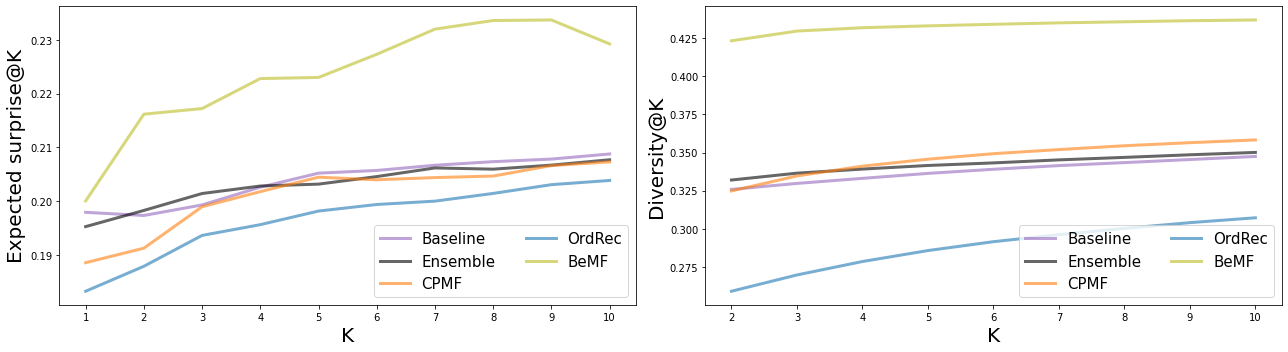

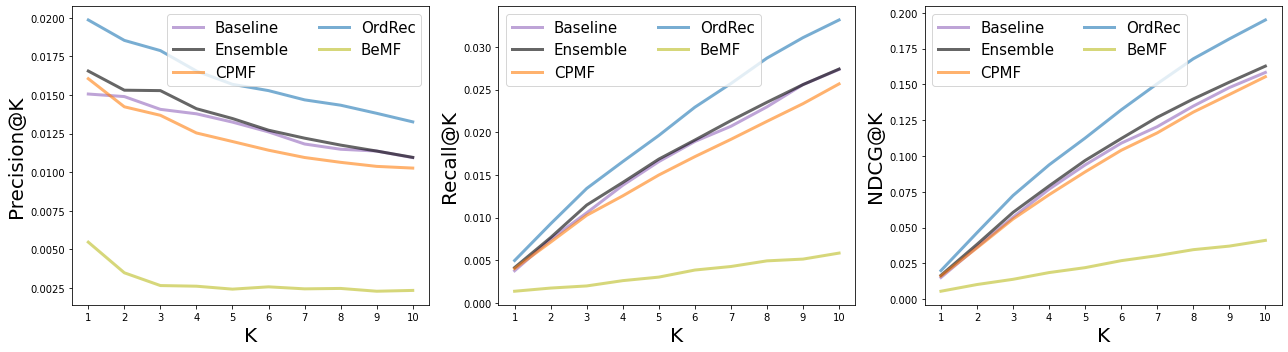

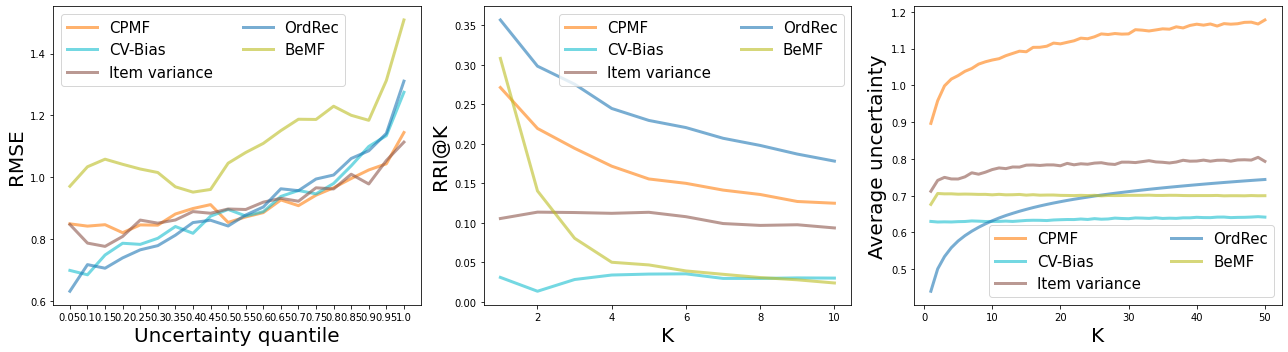

In [8]:
# Load
results = {}
for key in os.listdir('Movielens/results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('Movielens/results', key), 'rb'))
results_df = pd.DataFrame.from_dict(results, orient='index')
keys = results_df.index.to_list()
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {keys[i]:colors[i] for i in range(len(keys))}

# Rating prediction evaluation
ratings = results_df[['RMSE', 'RPI', 'Classification']]
print(ratings)

# Diversity and novelty
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec', 'BeMF']
f, ax = plt.subplots(ncols=2, figsize=(18, 5))
for key in keys:
    ax[0].plot(np.arange(1, 11), results_df['Novelty'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(2, 11), results_df['Diversity'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Expected surprise@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xticks(np.arange(2, 11))
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Diversity@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('Movielens/plots/diversity_novelty.pdf')

# Top-K accuracy metrics
f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results_df['Precision'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results_df['Recall'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 11), results_df['NDCG'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('Movielens/plots/accuracy.pdf')

# Uncertainty
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
keys = ['CPMF', 'CV-Bias', 'Item variance', 'OrdRec', 'BeMF']
for key in keys:
    ax[0].plot(np.arange(1, 21), results_df['Quantile RMSE'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results_df['RRI'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 51), results_df['Uncertainty'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 21))
ax[0].set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax[0].set_xlabel('Uncertainty quantile', fontsize=20)
ax[0].set_ylabel('RMSE', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('RRI@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('Average uncertainty', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()

In [7]:
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('Movielens/checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('Movielens/checkpoints/bemf', min(files, key=files.get)))
model.recommend(2)

,scores,uncertainties
0,5.0,0.680258
511,5.0,0.727298
191,5.0,0.665990
193,5.0,0.699050
194,5.0,0.665339
525,5.0,0.732785
197,5.0,0.680227
522,5.0,0.723604
201,5.0,0.641416
208,5.0,0.691505
